In [1]:
import numpy as np
# from cart_pole_env import CartPoleSwingUpEnv
# from cart_pole_model import CartPoleModel
from custom_cartpoleswingup import CartPoleSwingUpEnv
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [52]:
class IndirectController(object):

    def __init__(self, model, task, T=20):
        self.T = T
        self.nu = model.action_space.shape[0]
        self.nx = model.observation_space.shape[0]
        self.u = [np.random.normal(0., 0.1, size=(self.nu,)) for t in range(T-1)]
        
        self.model = model
        self.task  = task
        
    def __call__(self, state):
        
        self.u[:-1] = self.u[1:]
        self.u[-1]  = np.zeros(self.nu)
        
        self.model.set_state(state)
        A = []
        B = []
        ldx = []
        ldu = []
        for t in range(self.T-1):
            ldx_t = self.task.ldx(self.model.state)
            ldu_t = self.task.ldu(self.u[t])
            
            self.model.step(self.u[t])
            A_t = self.model.A
            B_t = self.model.B

            A.append(A_t)
            B.append(B_t)
            ldx.append(ldx_t)
            ldu.append(ldu_t)
        
        _rho = []
        rho = np.zeros(self.nx)
        for t in reversed(range(self.T-1)):
            rho = np.dot(A[t].T, rho) + ldx[t]
            self.u[t] = -np.dot(B[t].T, rho) + self.u[t]
            _rho.append(rho.copy())
        clear_output(wait=True)
        plt.plot(_rho)
        plt.pause(0.01)
        return self.u[0].copy()
    

In [3]:
env = CartPoleSwingUpEnv()
task = env.task


In [53]:
model = CartPoleSwingUpEnv()
controller = IndirectController(model, task, T=50)



In [54]:
state = env.reset()
actions = []
log = {
    'states' : [],
    'next_states' : [],
    'actions' : []
}
for _ in range(800):
    action = controller(state)
    next_state = env.step(action)
    env.render()
    log['states'].append(state.copy())
    log['next_states'].append(next_state.copy())
    log['actions'].append(action.copy())
    
    state = next_state

KeyboardInterrupt: 

In [47]:
actions = np.stack(log['actions'])

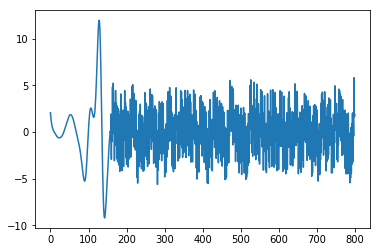

In [48]:
plt.plot(actions)
# plt.ylim(-1,1)